<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_4/20_NeuralODE_system_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural differential equations
- Blog:https://medium.com/towards-data-science/modeling-dynamical-systems-with-neural-ode-a-hands-on-guide-71c4cfdb84dc
- Code: https://github.com/ShuaiGuo16/neuralODE

### Objective

In this notebook, we implement the **Neural ODE** approach to model a dynamical system described by the *ordinary differential equation* (ODE).

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=0.7)

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Target Dynamical System: Logistic Growth Model

In this notebook, we investigate a specific dynamical system called [logistic growth system](https://services.math.duke.edu/education/ccp/materials/diffeq/logistic/logi1.html). This system is widely used in biology and ecology for modeling animal population growth under limited resources:

\begin{equation}
\frac{dp(t)}{dt} = rp(t)(1-\frac{p(t)}{k}) - H(p(t)).
\end{equation}

Here, $p(t)$ denotes the population size at time $t$, $r$ and $k$ represent the intrinsic growth rate of the population and carrying capacity of the environment, respectively.

$H(\cdot)$ is a harvesting function and reflects the removal of the animal population due to harvesting (or culling). In the current study, we adopt the following expression for $H(\cdot)$:

\begin{equation}
H(p(t)) = min(h \cdot p, H_{max}),
\end{equation}

where harvesting is proportional to the population size (harvesting rate $h$), but is capped at a maximum value $H_{max}$, for the purpose of sustainable management.

In [2]:
def logistic_growth(t, p, r, k, h, H_max):
    """
    ODE for logistic growth model.

    Inputs:
    -------
    t: time
    p: population size
    r: intrinsic growth rate
    k: carrying capacity
    h: harvesting rate
    H_max: maximum harvesting capacity

    Output:
    -------
    dpdt: Change rate of population size.
    """

    dpdt = r*p*(1-p/k) - min(h*p, H_max)

    return dpdt

### 2. Case Study: Dynamic Discovery

In this section, we tackle the first case study, i.e., dynamic discovery.

Here, we assume that while the harvesting function is known (controlled by human activity), the exact functional form that governs the *natural dynamics* of the population evolution remains unknown:

\begin{equation}
\frac{dp}{dt} = f_{unknown}(p) - min(h \cdot p, H_{max}).
\end{equation}

This case study has practical meaning as for real-world complex dynamica systems, it is often challenging to derive an explicit expression to describe the system dynamics. However, with the Neural ODE approach, we can potentially infer this underlying functional form from observational data.

#### 2.1 Strategy

The key idea of identifying hidden dynamics in Neural ODE is to approximate the unknown function $f_{unknown}(p)$ with a neural network:

\begin{equation}
\frac{dp}{dt} = f_{NN}(p) - min(h \cdot p, H_{max}).
\end{equation}

By training the $f_{NN}(p)$ based on the observation data of $p$, we are able to obtain a predictive model that takes in the population size p, and outputs the population change induced by the natural dynamics, thus completing the ODE.

Since we can only observe the population size $p$ and not its derivative $dp/dt$, we need to find a way to approximate those derivatives to facilitate training. Fortunately, traditional numerical methods for solving ODE has provided us with a range of techniques to discretize the derivatives. In this study, we opt for a simple Euler scheme to approximate the $dp/dt$ term:

\begin{equation}
\frac{dp}{dt} = \frac{p_{i+1}-p_{i}}{\Delta t},
\end{equation}

where $p_{i}$ and $p_{i+1}$ indicate the population size at the current and subsequent time steps, respectively, and $\Delta t$ denotes the time interval between these steps. We can then substitute this discretized version of $dp/dt$ back into the ODE:

\begin{equation}
\frac{p_{i+1}-p_{i}}{\Delta t} = f_{NN}(p_{i}) - min(h \cdot p_{i}, H_{max}).
\end{equation}

#### 2.2 Data Generation

To begin with, let's generate the observation data required for training the Neural ODE model. Toward that end, we assign a specific set of values to the ODE parameters and leverage the scipy ODE solver to simulate the corresponding dynamical system for a given timespan. This obtained time trace will serve as our training dataset.

Note that here the true ODE model is used only for creating the observation data. Later, we will assume that we have no access to the complete  form of the underlying ODE, and instead train a neural network model to infer the unknown dynamics based on the observation data.

In [3]:
# Set parameters
r, k, h, H_max = 0.1, 1000, 0.01, 5

# Initial condition
p_0 = 20

# Simulation time span
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve ODE
solution = solve_ivp(logistic_growth, t_span, [p_0],
                     t_eval=t_eval, args=(r, k, h, H_max))

Here, we visualize the general trend of the population evolution given the set ODE parameters.

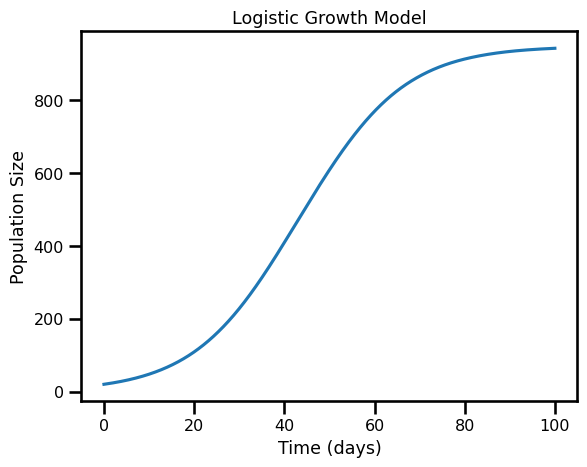

In [4]:
plt.plot(solution.t, solution.y[0])
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.title('Logistic Growth Model')
plt.show()

#### 2.3 Data organization

Next, we organize the obtained dataset into a proper format suitable for model training. There are several practical considerations worth discussing when preparing the dataset:

1. **windowing**: The entire dataset contains one time series of 100 days in real-time. Instead of overwhelming the model by feeding the entire time series, we could instead divide the full dataset into smaller chunks of continuous data samples. By processing shorter sequences at a time, we made it easier for the model to capture the complex dynamics, we greatly increased the diversity of the training data (e.g., every segment of time serie starts with a different initial condition), thus promoting the generalization capability of the model, as well as reducing the memory and computational resources for training.

2. **Overlapping**: To ensure continuity in the data, we allow adjacent windows to share a portion of data, i.e., the end of one window overlaps with the beginning of the next. This practice helps the model to maintain context across window boundaries, and effectively augment the dataset as each data point is used in multiple windows but with different contexts.

3. **Multi-Step Ahead Prediction**: To be practically useful, the model should be able to perform long-term forecasting. In practice, this is usually achieved in an autoregressive manner, i.e., the model uses its prediction at the current time step as inputs and predicts for the next time step. As a result, our training procedure should also align with such scenarios: during training, instead of using the actual observed values for each subsequent prediction step, the model uses its previous prediction as the input for the next prediction. This way improves the model's predictive accuracy and robustness for long-term forecasting tasks.

In [5]:
def create_windows(p_series, t_series, seq_length, overlap_length):
    """
    Create windows from the given time series data.
    Overlapping is introduced to ensure context continuity.

    Inputs:
    -------
    p_series: time series of observed population size
    t_series: observed time
    seq_length: intrinsic growth rate
    overlap_length: carrying capacity

    Output:
    -------
    p_windows: segmented window array of population size
    t_windows: segmented window array of the time
    """

    p_windows, t_windows = [], []

    step_size = seq_length - overlap_length
    beg_index = 0

    while (end_idx := beg_index + seq_length) <= len(p_series):

        # Construct P array
        p_windows.append(p_series[beg_index:end_idx])

        # Calculate time intervals
        time_intervals = t_series[beg_index:end_idx] - t_series[beg_index]
        t_windows.append(time_intervals)

        beg_index += step_size

    return np.array(p_windows), np.array(t_windows)

In [6]:
# Compile dataset
p_windows, t_windows = create_windows(solution.y[0][:, np.newaxis], t_eval, seq_length=20, overlap_length=10)
print(f"p_windows array dimension: {p_windows.shape}")

p_windows array dimension: (999, 20, 1)


In [7]:
# Create TensorFlow Dataset
p_windows = p_windows.astype('float32')
t_windows = t_windows.astype('float32')

batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((p_windows, t_windows))

We split the entire dataset into a train set and a validation set. This validation set can be used to monitor the learning progress of the model and facilitate learning rate scheduling.

Toward that end, we can randomly shuffle the dataset first and then select the first 80% for training and the remaining 20% for validation. It is worth mentioning that this way of splitting the dataset actually does not violate the temporal order: the shuffling operation only acts on the first dimension of `p_windows`, i.e., it rearranges these windows as complete units. Since each window still preserves its original temporal sequence, the overall temporal consistency of the data is not violated.

In [8]:
# Train/validation split
split_ratio = 0.8
train_num = int(split_ratio*len(p_windows))

# Split the dataset
dataset = dataset.shuffle(buffer_size=100000)
train_dataset = dataset.take(train_num)
val_dataset = dataset.skip(train_num)

# Batch the train & val datasets
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=100000)
val_dataset = val_dataset.batch(batch_size)

### 3. Neural ODE Solution

#### 3.1 Define the neural network model

Here, we use a standard feed-forward neural network to represent $f_{NN}(\cdot)$. This network takes a scalar value $p(t)$ (the population size at time $t$) as input and outputs a scalar value that denotes the population change rate induced by the natural dynamics (see ODE above).

To compute the final population change rate (induced by both natural dynamics and harvesting function), we define a custom layer to perform the calculation.

In [9]:
class PopulationChangeLayer(tf.keras.layers.Layer):
    def __init__(self, h, H_max, **kwargs):
        """
        Constructor for the custom layer for computing the population change rate.

        Inputs:
        -------
        h: harvesting rate
        H_max: maximum harvesting capacity
        """
        super(PopulationChangeLayer, self).__init__(**kwargs)
        self.h = h
        self.H_max = H_max

    def call(self, inputs, natural_dynamcis, *args, **kwargs):
        """
        This layer takes the results of natural dynamics and adds the effect of harvesting.

        Inputs:
        -------
        inputs: population size
        natural_dynamcis: population change rate induced by natural dynamics
        """

        # The governing ODE
        dp_dt = natural_dynamcis - tf.minimum(self.h*inputs, self.H_max)

        return dp_dt

In [10]:
def define_model(input_dim, hidden_dims, output_dim, init_lr, h, H_max):
    """
    Construct a standard feed-forward NN for Neural ODE.

    Inputs:
    -------
    input_dim: input dimension
    hidden_dims: list, dimensions for hidden layers
    output_dim: output dimension
    init_lr: initial learning rate
    h: harvesting rate
    H_max: maximum harvesting capacity

    Outputs:
    --------
    model: the compiled neural network model
    """

    # Input layer
    input_layer = keras.layers.Input(shape=(input_dim,))

    # Hidden layers
    for i, neuron_num in enumerate(hidden_dims):
        if i == 0:
            hidden = keras.layers.Dense(neuron_num, activation="selu", kernel_initializer='LecunNormal')(input_layer)

        else:
            hidden = keras.layers.Dense(neuron_num, activation="selu", kernel_initializer='LecunNormal')(hidden)

    # Population change rate induced by natural dynamics
    natural_dynamics = keras.layers.Dense(output_dim, activation="linear")(hidden)

    # Total population change rate
    dp_dt = PopulationChangeLayer(h, H_max)(input_layer, natural_dynamics)

    # Compile model
    model = tf.keras.models.Model(inputs=input_layer, outputs=[dp_dt, natural_dynamics])
    optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr)
    model.compile(optimizer=optimizer)

    return model

#### 3.2 Define loss function

Here, we define a custom loss function to facilitate neural ODE training. Specifically, we implement the logic of multi-step ahead prediction to improve the model's accuracy and robustness for performing long-term forecasting.

In [11]:
@tf.function
def train_step(p_batch, t_batch, ode_nn):
    """Calculate loss and its gradients with respect to network model parameters.

    Inputs:
    ----
    p_batch: a batch of population evolution data, [batch_size, timesteps, feature_dim]
    t_batch: a batch of time evolution data, [batch_size, timesteps, feature_dim]
    ode_nn: neural ODE model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    gradients: gradients of the ODE loss with respect to network model parameters.
    """

    with tf.GradientTape() as tape:
        batch_size, seq_length, _ = p_batch.shape
        loss = 0

        # Batch processing each step of the time series
        p = p_batch[:, 0]
        for i in range(seq_length - 1):

            # Calculate time step
            delta_t = t_batch[:, i+1] - t_batch[:, i]

            # Calculate the population change rate
            dp_dt, _ = ode_nn(p)

            # Euler scheme
            p = p + delta_t[:, tf.newaxis]*dp_dt

            # Sum loss for the whole batch (for the current time step)
            loss += tf.reduce_mean(tf.square(p - p_batch[:, i+1]))

        # Average the loss over all time steps
        loss /= (seq_length - 1)

    # Compute gradients
    gradients = tape.gradient(loss, ode_nn.trainable_variables)

    return loss, gradients

In [12]:
def val_step(p_batch, t_batch, ode_nn):
    """Calculate validation loss.

    Inputs:
    ----
    p_batch: a batch of population evolution data, [batch_size, timesteps, feature_dim]
    t_batch: a batch of time evolution data, [batch_size, timesteps, feature_dim]
    ode_nn: neural ODE model

    Outputs:
    --------
    loss: calculated ODE loss
    """
    batch_size, seq_length, _ = p_batch.shape
    loss = 0

    # Batch processing each step of the time series
    p = p_batch[:, 0]
    for i in range(seq_length - 1):

        # Calculate time step
        delta_t = t_batch[:, i+1] - t_batch[:, i]

        # Calculate the population change rate
        dp_dt, _ = ode_nn(p)

        # Euler scheme
        p = p + delta_t[:, tf.newaxis]*dp_dt

        # Sum loss for the whole batch (for the current time step)
        loss += tf.reduce_mean(tf.square(p - p_batch[:, i+1]))

    # Average the loss over all time steps
    loss /= (seq_length - 1)

    return loss

#### 3.3 Training logic



In [13]:
# Setup NN hyperparameters
input_dim, output_dim = 1, 1
hidden_dims = [5, 5, 5]

# Instantiate NN
ode_nn = define_model(input_dim, hidden_dims, output_dim, init_lr=1e-2, h=h, H_max=H_max)

# Training Loop
num_epochs = 600
train_loss_hist, val_loss_hist = [], []

with tf.device("CPU:0"):

    # Configure learning rate scheduler
    ode_nn_callbacks = tf.keras.callbacks.CallbackList(
                      [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=50)],
                        add_history=False, model=ode_nn)

    for epoch in range(num_epochs):

        # Initialize epoch-wise losses
        train_total_loss, val_total_loss = 0, 0

        # Training
        for p_batch, t_batch in train_dataset:

            # Calculate loss & gradients
            train_loss, gradients = train_step(p_batch, t_batch, ode_nn)

            # Update parameters
            ode_nn.optimizer.apply_gradients(zip(gradients, ode_nn.trainable_variables))

            # Accumulate loss
            train_total_loss += train_loss

        # Normalize loss
        train_total_loss /= len(train_dataset)

        # Validation loop
        for p_batch, t_batch in val_dataset:
            val_loss = val_step(p_batch, t_batch, ode_nn)
            val_total_loss += val_loss

        # Normalize validation loss
        val_total_loss /= len(val_dataset)

        # Callbacks
        ode_nn_callbacks.on_epoch_end(epoch, logs={'val_loss': val_total_loss})

        # Logging
        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_total_loss.numpy():.3e}, Val Loss: {val_total_loss.numpy():.3e}")
        #print(f"lr: {ode_nn.optimizer.lr.numpy():.3e}")

        train_loss_hist.append(train_total_loss)
        val_loss_hist.append(val_total_loss)

        # Reshuffle train dataset
        dataset = dataset.shuffle(buffer_size=100000)
        train_dataset = dataset.take(train_num).shuffle(buffer_size=100000).batch(batch_size)
        val_dataset = dataset.skip(train_num).batch(batch_size)

Epoch 1:
Train Loss: 1.278e+00, Val Loss: 1.274e+00
Epoch 2:
Train Loss: 1.225e+00, Val Loss: 1.201e+00
Epoch 3:
Train Loss: 1.140e+00, Val Loss: 1.056e+00
Epoch 4:
Train Loss: 1.060e+00, Val Loss: 9.329e-01
Epoch 5:
Train Loss: 1.050e+00, Val Loss: 1.008e+00
Epoch 6:
Train Loss: 9.785e-01, Val Loss: 1.013e+00
Epoch 7:
Train Loss: 8.909e-01, Val Loss: 8.572e-01
Epoch 8:
Train Loss: 8.784e-01, Val Loss: 8.005e-01
Epoch 9:
Train Loss: 8.117e-01, Val Loss: 9.200e-01
Epoch 10:
Train Loss: 8.279e-01, Val Loss: 8.283e-01
Epoch 11:
Train Loss: 7.950e-01, Val Loss: 8.077e-01
Epoch 12:
Train Loss: 7.343e-01, Val Loss: 6.257e-01
Epoch 13:
Train Loss: 6.553e-01, Val Loss: 6.240e-01
Epoch 14:
Train Loss: 5.833e-01, Val Loss: 5.143e-01
Epoch 15:
Train Loss: 5.232e-01, Val Loss: 4.932e-01
Epoch 16:
Train Loss: 4.375e-01, Val Loss: 4.199e-01
Epoch 17:
Train Loss: 4.028e-01, Val Loss: 3.963e-01
Epoch 18:
Train Loss: 3.427e-01, Val Loss: 3.450e-01
Epoch 19:
Train Loss: 3.108e-01, Val Loss: 2.683e-01
Ep

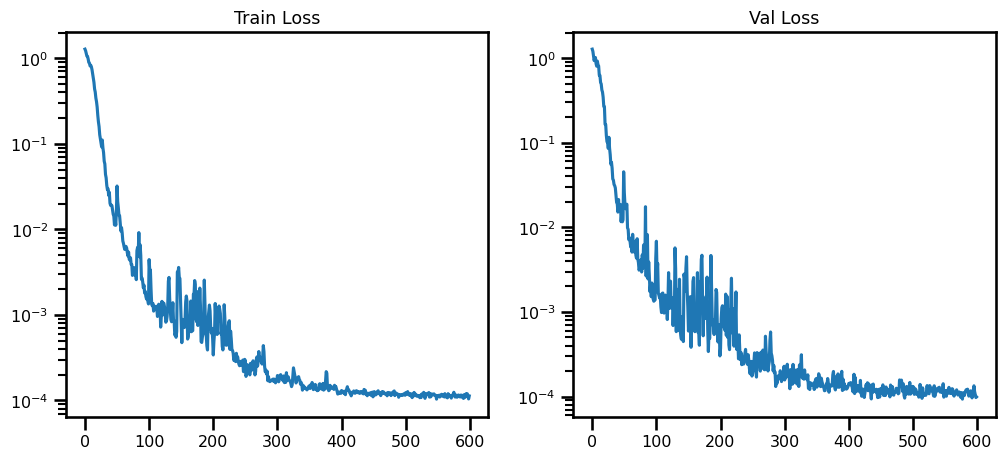

In [14]:
# History
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(num_epochs), train_loss_hist)
ax[1].plot(range(num_epochs), val_loss_hist)
ax[0].set_title('Train Loss')
ax[1].set_title('Val Loss')
for axs in ax:
    axs.set_yscale('log')

### 4. Assessment

#### 4.1 Accuracy of learned dynamics

To begin with, we assess the accuracy of the learned dynamics. For that, we compare the predicted and true population change rates induced by the natural dynamics, as a function of the population size.

In [16]:
p = solution.y[0]

# True relationship
ground_truth = r*p*(1-p/k)

pred = ode_nn.predict(p, batch_size=128)

'''
# Predicted relationship
with tf.device("CPU:0"):
    pred = ode_nn.predict(p, batch_size=128)
'''

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


'\n# Predicted relationship\nwith tf.device("CPU:0"):\n    pred = ode_nn.predict(p, batch_size=128)\n    '

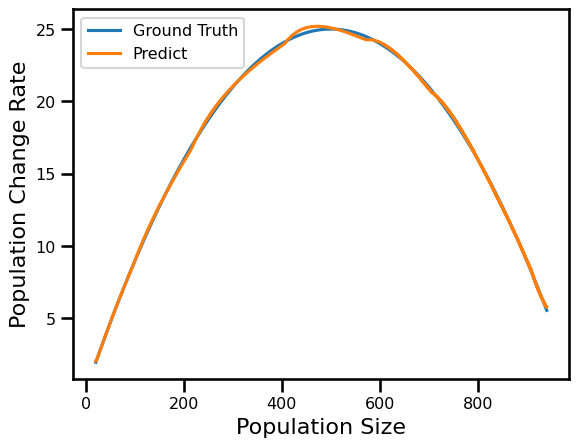

In [17]:
fig, ax = plt.subplots()
ax.plot(p, ground_truth, label='Ground Truth')
ax.plot(p, pred[1].flatten(), label='Predict')
ax.set_xlabel("Population Size", fontsize=16)
ax.set_ylabel("Population Change Rate", fontsize=16)
ax.legend();

#### 4.2 Long-term forecasting

Next, we test if the trained Neural ODE model can perform long-term integration given the initial population size used in training. Note that unlike the training phase, here, we **only** supply the trained model with the initial population size. The model will autoregressively predict the entire population evolution.

First, let's define a helper function to make predictions with Neural ODE model.

In [18]:
@tf.function
def neuralODE_pred(p_init, t, ode_nn, h, H_max):
    """
    Using trained neural ODE to autogressively predict the population evolution.

    inputs:
    -------
    p_init: initial population size
    t: array of timestamps
    ode_nn: trained neural ODE model
    h: harvesting rate
    H_max: maximum harvesting capacity

    Outputs:
    --------
    preds: array of population evolution
    """

    preds = tf.TensorArray(dtype=tf.float32, size=tf.size(t))
    preds = preds.write(0, p_init)
    p = tf.constant([[p_init]], dtype=tf.float32)

    # Loop over time steps
    for i in tf.range(tf.size(t)-1):

        # Calculate time interval
        delta_t = t[i+1]-t[i]

        # Calculate population change rate
        _, natural_dynamics = ode_nn(p)
        dp_dt = natural_dynamics - tf.minimum(h*p, H_max)

        # Euler integration scheme
        p = p + delta_t*dp_dt

        # Store prediction
        preds = preds.write(i+1, p[0][0])

    return preds.stack()

Next, we simulate the population growth using the same setting employed during model training.

In [19]:
# Set parameters
r, k, h, H_max = 0.1, 1000, 0.01, 5

# Initial condition
p_0 = 20

# Simulation time span
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve ODE
solution = solve_ivp(logistic_growth, t_span, [p_0],
                     t_eval=t_eval, args=(r, k, h, H_max))

In [20]:
# Neural ODE predictions
t_eval = t_eval.astype(np.float32)
predictions = neuralODE_pred(p_0, t_eval, ode_nn, h, H_max)

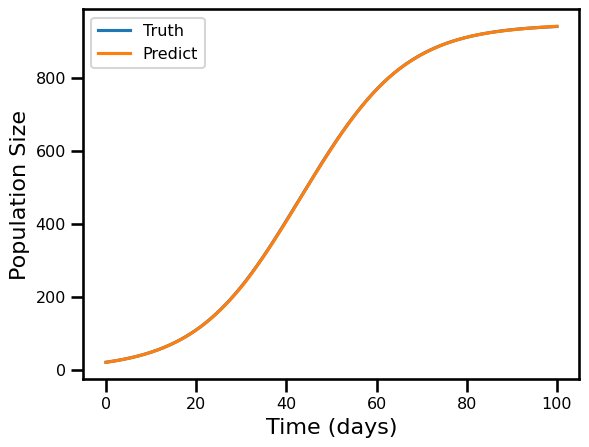

In [21]:
fig, ax = plt.subplots()
ax.plot(t_eval, solution.y[0], label='Truth')
ax.plot(t_eval, predictions, label='Predict')
ax.set_xlabel("Time (days)", fontsize=16)
ax.set_ylabel("Population Size", fontsize=16)
ax.legend();

#### 4.3 Dynamical modeling with different settings

Finally, we test if the trained Neural ODE model can predict the population growth given a different set of initial condition and harvesting setting. Specifically, we set the new initial population as $p_0=60$, and the harvesting parameters $h=0.05$, $H_{max} = 40$.

We first simulate the population growth under the new setting.

In [22]:
# Set new harvesting parameters
h_new, H_max_new = 0.05, 40

# Initial condition
p_0_new = 60

# Simulation time span
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve ODE
solution = solve_ivp(logistic_growth, t_span, [p_0_new],
                     t_eval=t_eval, args=(r, k, h_new, H_max_new))

Afterward, we use the trained Neural ODE to predict the population growth.

In [23]:
# Neural ODE predictions
t_eval = t_eval.astype(np.float32)
predictions = neuralODE_pred(p_0_new, t_eval, ode_nn, h_new, H_max_new)

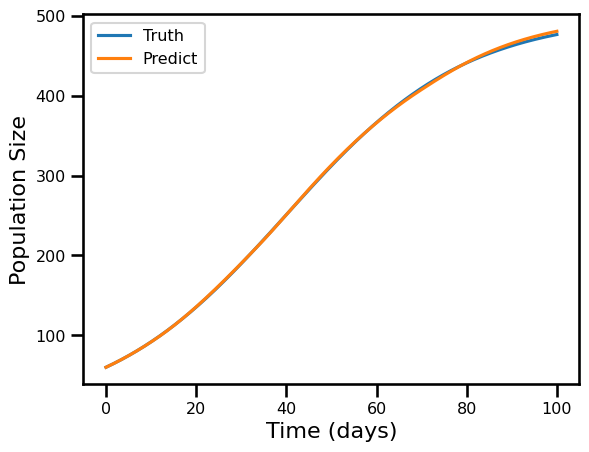

In [24]:
fig, ax = plt.subplots()
ax.plot(t_eval, solution.y[0], label='Truth')
ax.plot(t_eval, predictions, label='Predict')
ax.set_xlabel("Time (days)", fontsize=16)
ax.set_ylabel("Population Size", fontsize=16)
ax.legend();